In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters as plotters


/home/kian/anaconda3/envs/thesis/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


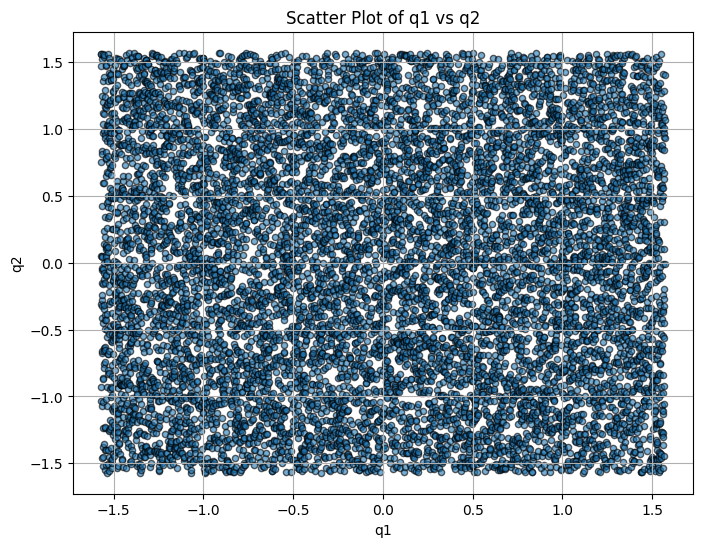

In [3]:
import numpy as np

# Number of samples
q1_low  = -torch.pi/2
q1_high = torch.pi/2
q2_low  = -torch.pi/2
q2_high = torch.pi/2
q1_d_low  = -torch.pi/2
q1_d_high = torch.pi/2
q2_d_low  = -torch.pi/2
q2_d_high = torch.pi/2


n_samples = 10000

# Generate uniformly distributed points for q1 and q2
q1 = torch.linspace(q1_low, q1_high, n_samples)
q2 = torch.linspace(q2_low, q2_high, n_samples)
q1_d = torch.linspace(q1_d_low, q1_d_high, n_samples)
q2_d = torch.linspace(q2_d_low, q2_d_high, n_samples)

idx = torch.randperm(q2.shape[0])
idx2 = torch.randperm(q1_d.shape[0])
idx3 = torch.randperm(q2_d.shape[0])

q2 = q2[idx]
q1_d = q1_d[idx2]
q2_d = q2_d[idx3]

# Stack q1 and q2 to get the 2D coordinates
points = torch.stack([q1, q2, q1_d, q2_d], axis=1)#.to(device)  # Shape will be (1000, 2)

# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(q1.numpy(), q2.numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Use TensorDataset to create the dataset
dataset = TensorDataset(points)

# Create the DataLoader with batch size and shuffling
batch_size = 512
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in dataloader:
    #print(batch[0])
    break  # Just to show one batch

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2

    def encoder_nn(self, q):
        theta_2 = self.encoder(q)
        return theta_2, theta_2
    
    def forward(self, q):
        
        J_h_1, theta_1 = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        
        J_h_2, theta_2 = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)
        
        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        theta = torch.stack((theta_1, theta_2), dim=1).squeeze(2)
        J_h = torch.cat((J_h_1, J_h_2), dim=1)
        J_h_ana = torch.cat((J_h_1, J_h_2_ana), dim=1)

        q_hat = self.decoder(theta)
        return(theta, J_h, q_hat, J_h_ana)

In [13]:
timer_datasplit = 0
timer_modelrun = 0
timer_mqcalc = 0
timer_mthcalc = 0
timer_lossterms = 0
timer_optimizer = 0
timer_plotter = 0

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271254.pth
Epoch:1, Loss:1.353462458
loss Jh unitary: tensor(0.9999, grad_fn=<MseLossBackward0>)


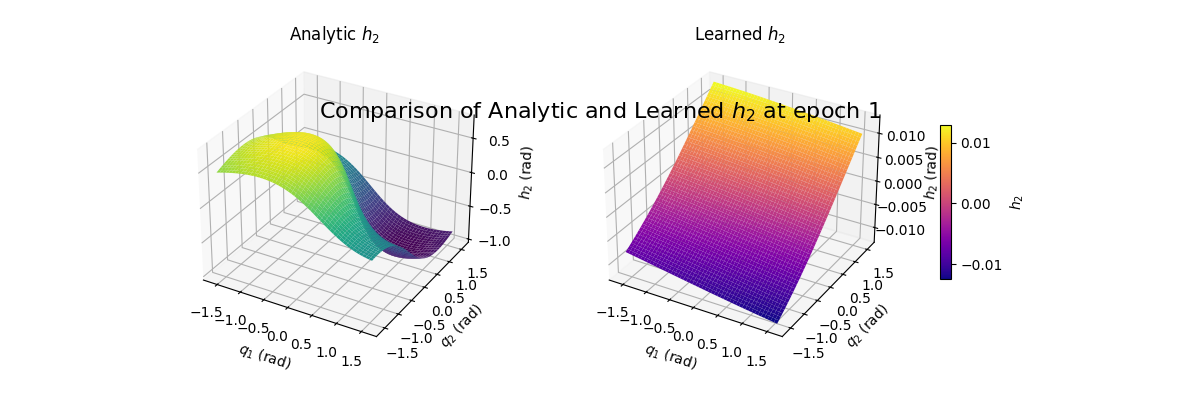

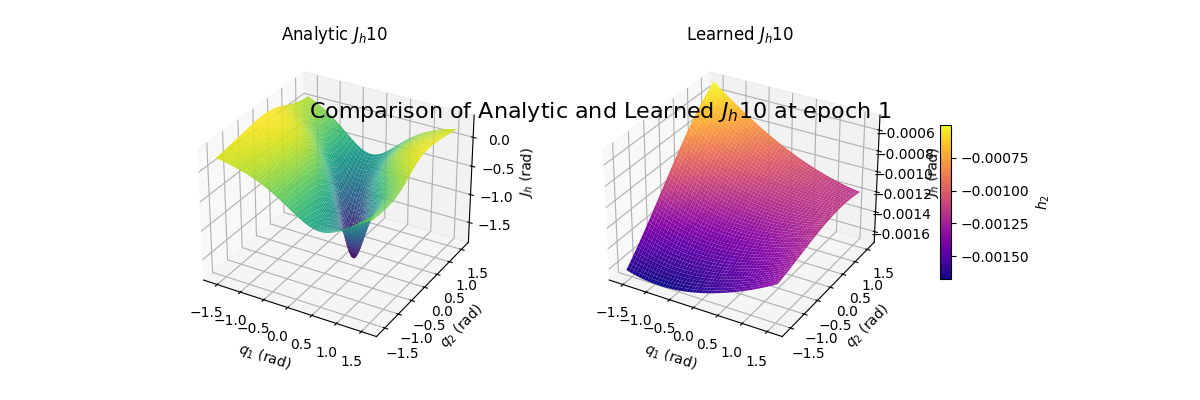

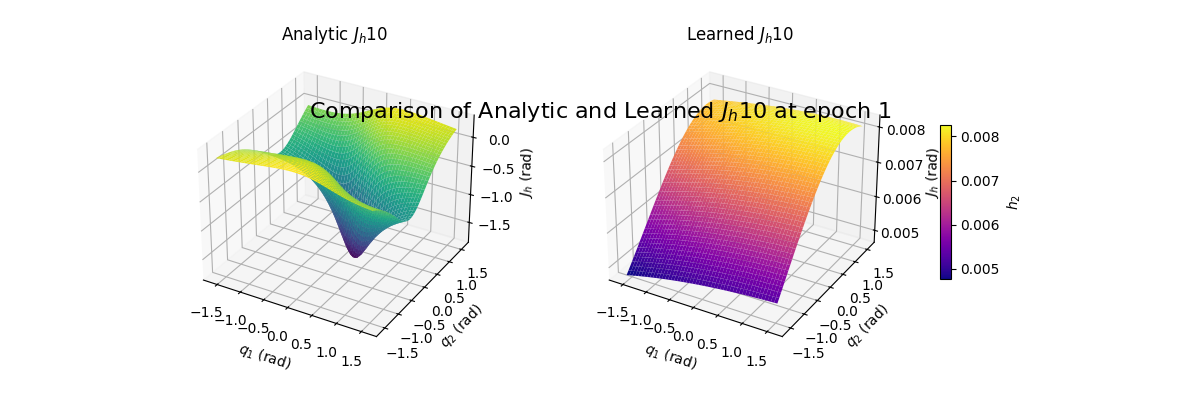

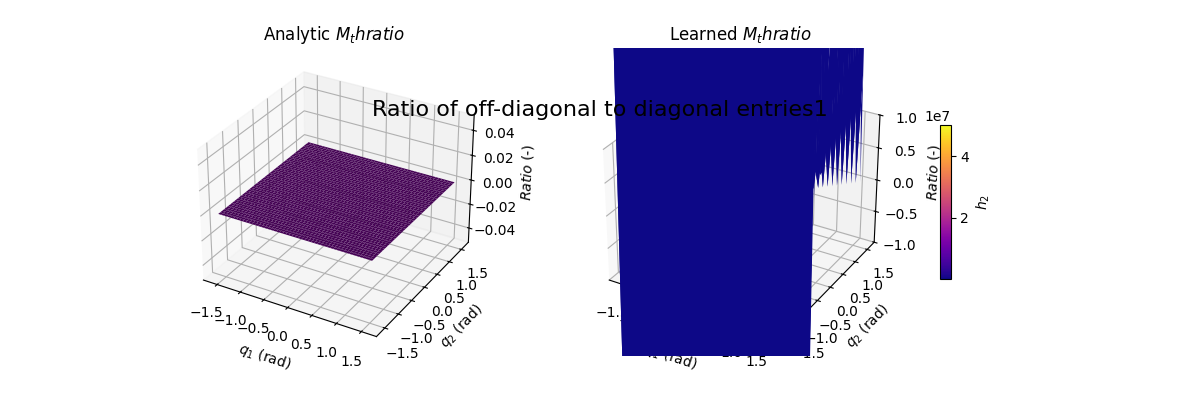

Epoch:11, Loss:1.312500238
loss Jh unitary: tensor(0.9999, grad_fn=<MseLossBackward0>)
Epoch:21, Loss:1.333609343
loss Jh unitary: tensor(0.9999, grad_fn=<MseLossBackward0>)
Epoch:31, Loss:1.309115648
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)
Epoch:41, Loss:1.267518520
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)
Epoch:51, Loss:1.273621917
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)


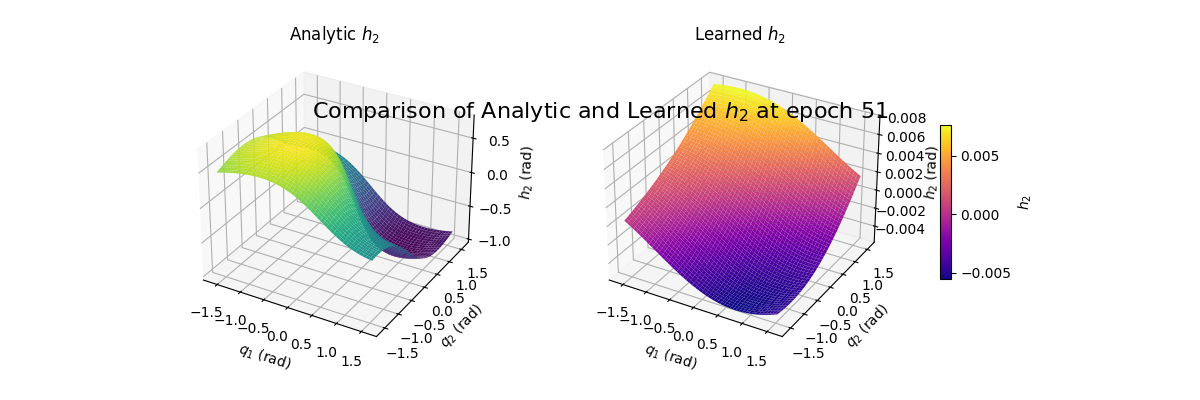

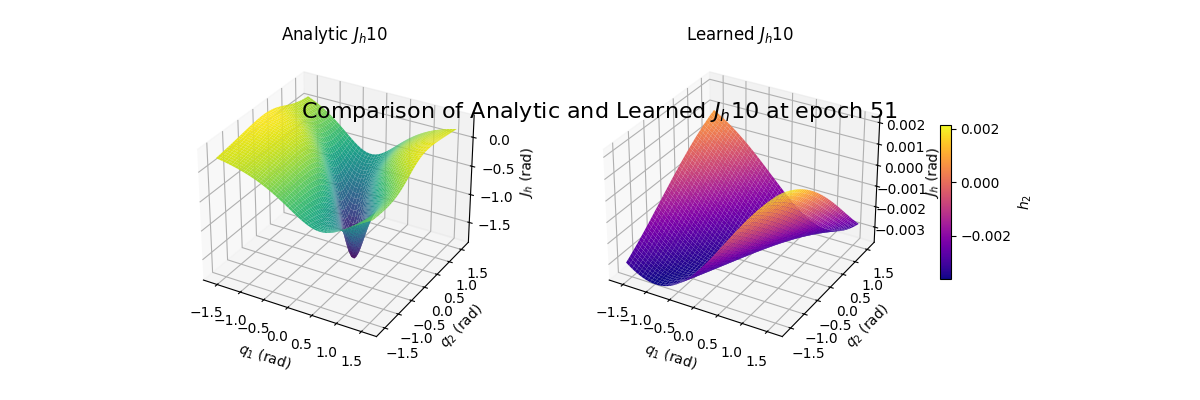

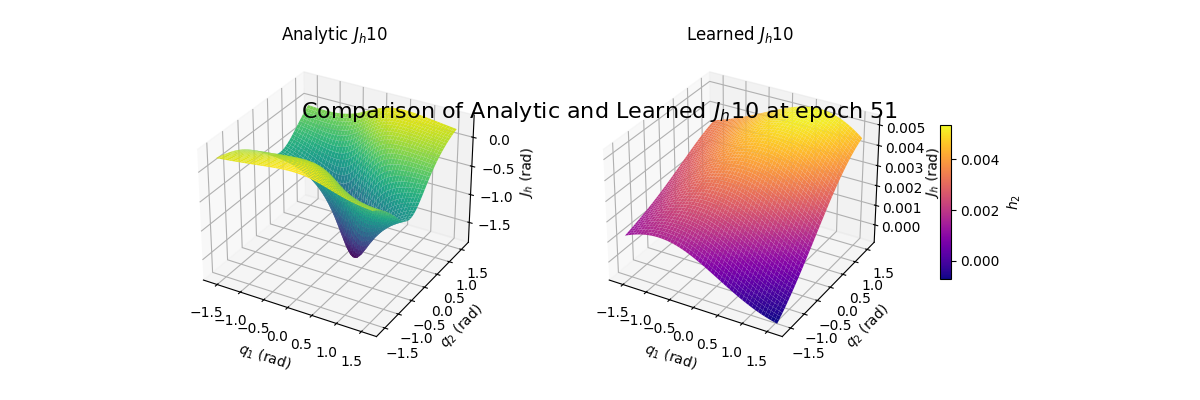

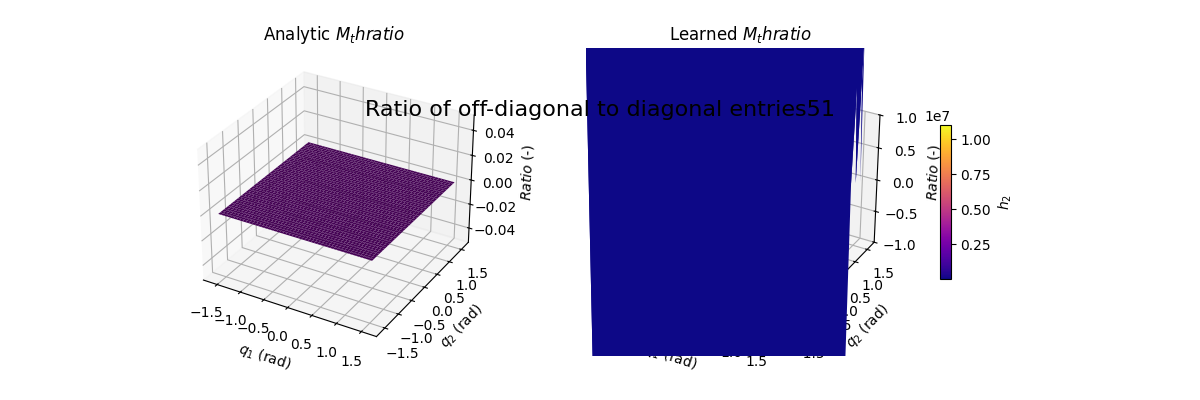

Epoch:61, Loss:1.286780000
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)
Epoch:71, Loss:1.267376661
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)
Epoch:81, Loss:1.284939289
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)
Epoch:91, Loss:1.241467237
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)
Epoch:101, Loss:1.247330427
loss Jh unitary: tensor(1.0000, grad_fn=<MseLossBackward0>)


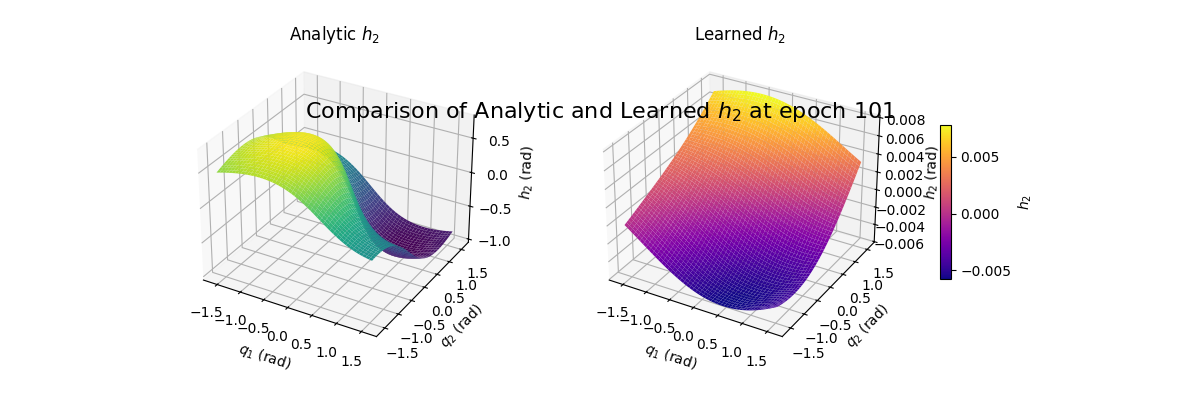

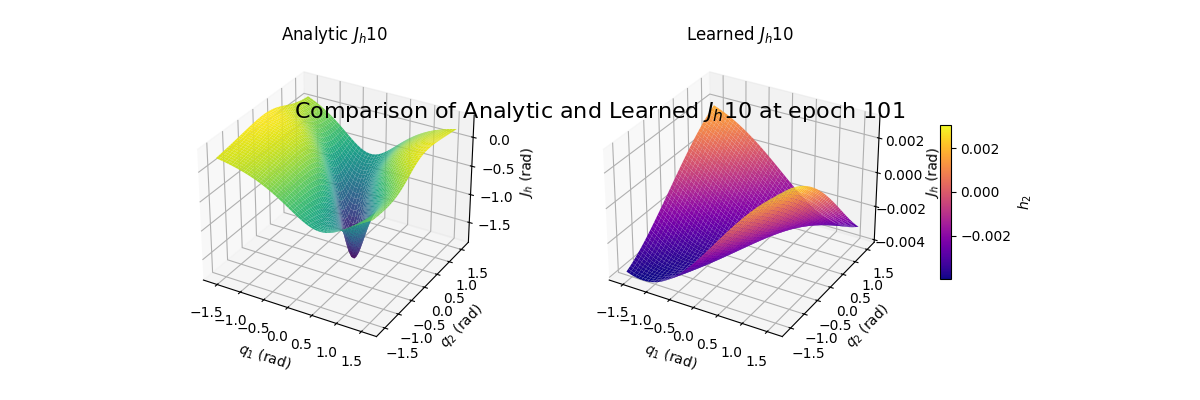

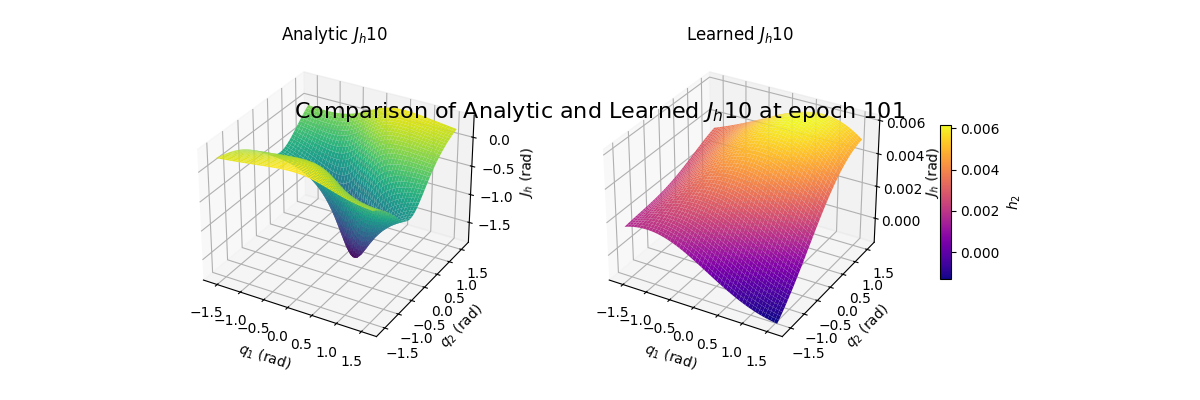

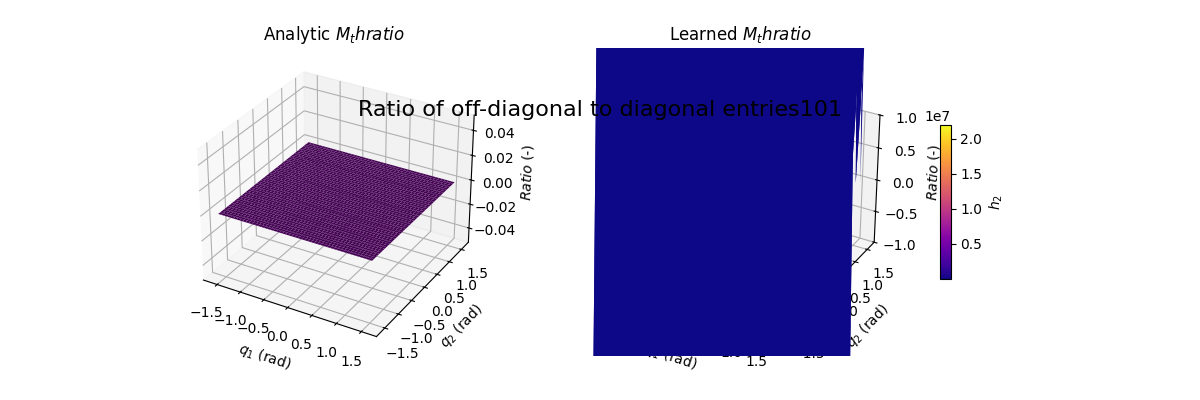

timer_datasplit: 0.05392292500619078
timer_modelrun: 11.099433451969162
timer_mqcalc: 1.361022810015129
timer_mthcalc: 1.900393098983841
timer_lossterms: 2.772788453969042
timer_optimizer: 6.1308344950048195
timer_plotter: 5.917267128999811
Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271254.pth
CPU times: user 2min 40s, sys: 261 ms, total: 2min 41s
Wall time: 33.1 s


In [14]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271226.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 101

print(file_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-6)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))


l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []


plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(dataloader):
        timer_datasplit -= time.perf_counter() 
        batch_size = batch[0].shape[0]
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        timer_datasplit += time.perf_counter()
        
        timer_modelrun -= time.perf_counter()
        theta, J_h, q_hat, J_h_ana = model(q)  
        timer_modelrun += time.perf_counter()
        
        timer_mqcalc -= time.perf_counter()
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))

        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)
        timer_mqcalc += time.perf_counter()

        timer_mthcalc -= time.perf_counter()
        M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)      
        timer_mthcalc += time.perf_counter()
        
        timer_lossterms -= time.perf_counter()
        loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_decoupling = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        l1_norm = loss_terms.loss_l1(model)

        loss = loss_decoupling + loss_J_h_unitary
        timer_lossterms += time.perf_counter()

        timer_optimizer -= time.perf_counter()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        timer_optimizer += time.perf_counter()

    timer_plotter -= time.perf_counter()
    if epoch % 10 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
        print("loss Jh unitary:", loss_J_h_unitary)
    if epoch % 50 == 0:
        plotters.plot_h2(model, device, rp, epoch)
        plotters.plot_J_h(model, device, rp, epoch, plot_index = 0)
        plotters.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters.plot_decoupling(model, device, rp, epoch)
    #scheduler.step()

    outputs.append((epoch, loss, q, q_hat, theta, M_th))
    timer_plotter += time.perf_counter()

print("timer_datasplit:", timer_datasplit)
print("timer_modelrun:", timer_modelrun)
print("timer_mqcalc:", timer_mqcalc)
print("timer_mthcalc:", timer_mthcalc)
print("timer_lossterms:", timer_lossterms)
print("timer_optimizer:", timer_optimizer)
print("timer_plotter:", timer_plotter)

torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")

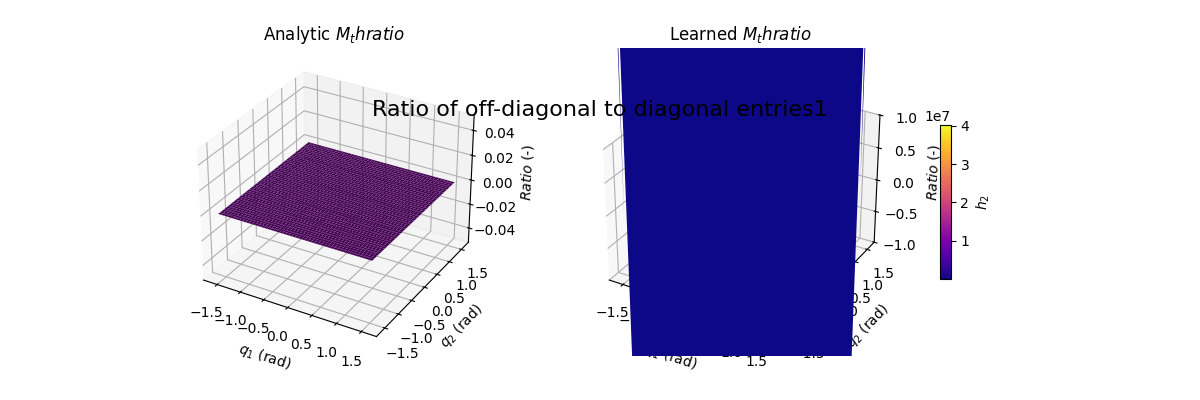

In [8]:

plotters.plot_decoupling(model, device, rp, epoch)

In [9]:
q_test = torch.tensor([[0.4167, -0.9167]]).to(device)
theta, J_h, q_hat, J_h_ana = model(q_test)

J_h_inv = torch.linalg.inv(J_h)
J_h_inv_trans = J_h_inv.transpose(1, 2)




print("J_h:\n", J_h.detach().cpu().numpy()[0])
print("J_h_inv:\n", J_h_inv.detach().cpu().numpy()[0])

M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q_test[0], q_test[0])
M_q = M_q.unsqueeze(0)
M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)
print("M_q:", M_q)
print("M_th:\n", M_th)


off_dia = M_th[:, 1,0]
diag_elements = M_th[:, [0, 1], [0, 1]]
diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
M_th_ratio = off_dia/diag_product
print("M_th_ratio:", M_th_ratio)

print("M_q:\n", M_q)

print("J_h_ana:\n", J_h_ana.detach().cpu().numpy()[0], "\n")
J_h_ana_inv = torch.linalg.pinv(J_h_ana)
J_h_ana_inv_trans = J_h_ana_inv.transpose(1,2)

print("J_h_ana_inv:\n", J_h_ana_inv.detach().cpu().numpy()[0], "\n")


M_th_ana, C_th_ana, G_th_ana = dynamics.dynamical_matrices_th(rp, q_test[0], q_test[0]) 
print("M_th_ana:", M_th_ana.detach().cpu().numpy())

J_h:
 [[-0.6318392  -1.992943  ]
 [-0.00309395 -0.00661011]]
J_h_inv:
 [[    3.3224354 -1001.71136  ]
 [   -1.5551096   317.58084  ]]
M_q: tensor([[[12.0000,  2.8221],
         [ 2.8221, 12.0000]]])
M_th:
 tensor([[[ 1.3232e+02, -3.8490e+04],
         [-3.8490e+04,  1.1456e+07]]], grad_fn=<UnsafeViewBackward0>)
M_th_ratio: tensor([-0.9886], grad_fn=<DivBackward0>)
M_q:
 tensor([[[12.0000,  2.8221],
         [ 2.8221, 12.0000]]])
J_h_ana:
 [[-0.6318392  -1.992943  ]
 [-0.71827465  0.06353932]] 

J_h_ana_inv:
 [[-0.04317627 -1.3542446 ]
 [-0.488082    0.4293473 ]] 

M_th_ana: [[ 3.       0.     ]
 [ 0.      20.93807]]


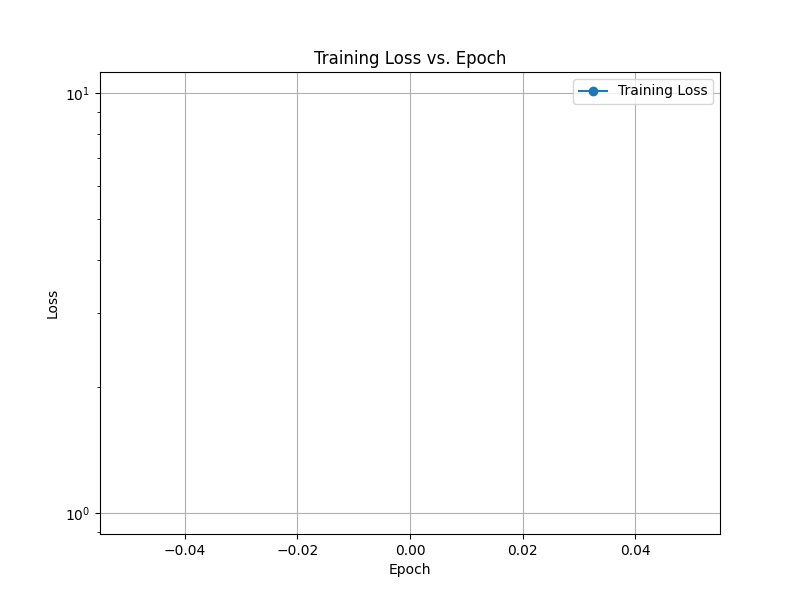

In [10]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='o', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
print(M_th)
print(M_th_ana)

tensor([[[ 1.3232e+02, -3.8490e+04],
         [-3.8490e+04,  1.1456e+07]]], grad_fn=<UnsafeViewBackward0>)
tensor([[ 3.0000,  0.0000],
        [ 0.0000, 20.9381]])


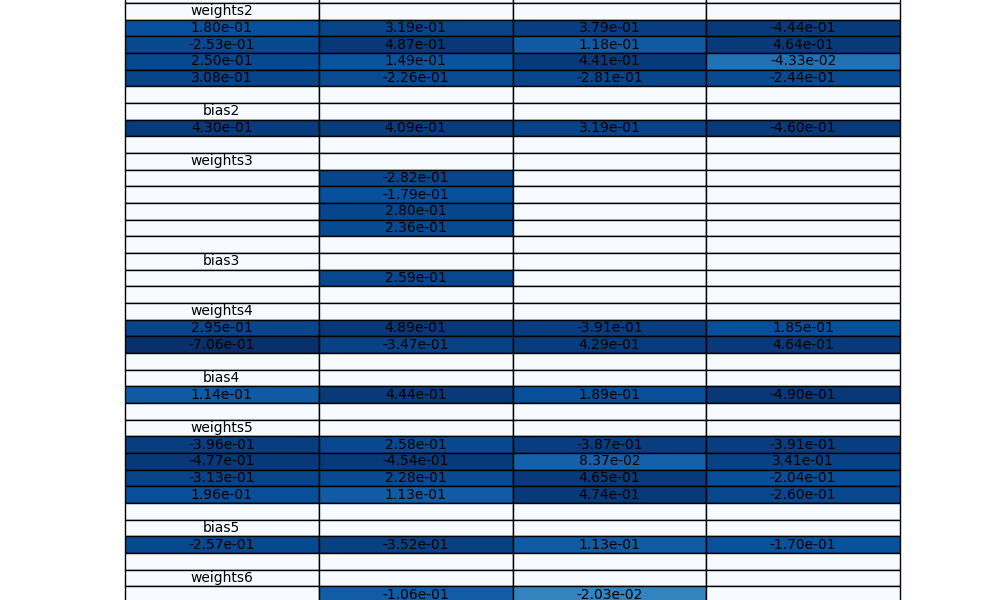

In [12]:
import random
import string

max_neurons = 4
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()